# NBA Winner Classifier

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
from collections import defaultdict

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

Autosaving every 60 seconds


### Utils functions

In [3]:
def filter_from(items, cond):
    return list(filter(cond, items))

In [4]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [5]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [25]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [6]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [7]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="prec", hue="model", style="model",
        markers=True, dashes=False)
    a.set_title(
        f"{experiment_name}-prec")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [8]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [9]:
metrics = ['prec', 'bal_acc', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='prec', filter_val=None):
    second_metric = 'bal_acc' if metric == 'prec' else 'prec'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model.isin(filter_val))
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [10]:
season_games = sg.load_season_games_dataset()

## Dataset


In [31]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [11]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [12]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)

(9599, 274)
0
(9461, 274)


In [190]:
df[df.SEASON >= 2012]

SEASON_ID  TEAM_ID_HOME TEAM_ABBREVIATION_HOME  \
GAME_ID                                                     
0021200019     22012    1610612739                    CLE   
0021200021     22012    1610612740                    NOH   
0021200022     22012    1610612760                    OKC   
0021200024     22012    1610612756                    PHX   
0021200025     22012    1610612747                    LAL   
...              ...           ...                    ...   
0021701226     22017    1610612740                    NOP   
0021701227     22017    1610612760                    OKC   
0021701228     22017    1610612746                    LAC   
0021701229     22017    1610612757                    POR   
0021701230     22017    1610612758                    SAC   

                    TEAM_NAME_HOME  GAME_DATE MATCHUP_HOME WL_HOME  MIN_HOME  \
GAME_ID                                                                        
0021200019     Cleveland Cavaliers 2012-11-02  CLE vs. CHI       L       240   
0021200021     New Orleans Hornets 2012-11-02  NOH vs. UTA       W       240   
0021200022   Oklahoma City Thunder 2012-11-02  OKC vs. POR       W       240   
0021200024            Phoenix Suns 2012-11-02  PHX vs. DET       W       240   
0021200025      Los Angeles Lakers 2012-11-02  LAL vs. LAC       L       240   
...                            ...        ...          ...     ...       ...   
0021701226    New Orleans Pelicans 2018-04-11  NOP vs. SAS       W       240   
0021701227   Oklahoma City Thunder 2018-04-11  OKC vs. MEM       W       240   
0021701228             LA Clippers 2018-04-11  LAC vs. LAL       L       240   
0021701229  Portland Trail Blazers 2018-04-11  POR vs. UTA       W       240   
0021701230        Sacramento Kings 2018-04-11  SAC vs. HOU       W       240   

            FGM_HOME  FGA_HOME  ...  HOME_OREB_L10  HOME_DREB_L10  \
GAME_ID                         ...                                 
0021200019        32        79  ...            4.0            4.0   
0021200021        37        81  ...          -11.0           -7.0   
0021200022        39        76  ...            2.0           16.0   
0021200024        40        92  ...            1.0            7.0   
0021200025        34        68  ...            7.0           -0.5   
...              ...       ...  ...            ...            ...   
0021701226        52        88  ...           -2.3            4.4   
0021701227        47        85  ...            3.8            3.2   
0021701228        41        83  ...            2.0           -5.5   
0021701229        41        89  ...            2.9           -0.1   
0021701230        38        80  ...            2.1           -4.5   

            HOME_REB_L10  HOME_AST_L10  HOME_STL_L10  HOME_BLK_L10  \
GAME_ID                                                              
0021200019           8.0           1.0          -1.0          -5.0   
0021200021         -18.0           2.0          -3.0          -2.0   
0021200022          18.0          -1.0          -4.0           0.0   
0021200024           8.0          -5.0          -2.0           8.0   
0021200025           6.5          -2.5          -6.0          -5.5   
...                  ...           ...           ...           ...   
0021701226           2.1           6.1           1.2           0.4   
0021701227           7.0          -1.8           1.9          -1.0   
0021701228          -3.5          -1.7           0.2          -0.3   
0021701229           2.8          -7.6          -0.4          -0.8   
0021701230          -2.4           0.9          -3.0          -0.5   

            HOME_TOV_L10  HOME_PF_L10  HOME_PTS_L10  HOME_PLUS_MINUS_L10  
GAME_ID                                                                   
0021200019           3.0          2.0           1.0                  4.0  
0021200021           1.0         -5.0         -18.0                -23.0  
0021200022           6.0          0.0         -32.0                

## Experiments

### Setup

In [86]:
# x_features = [
#     'FG_PCT_MEAN_AWAY',
#     'FG_PCT_MEAN_HOME',
#     'FT_PCT_ML10_AWAY',
#     'HOME_FG3_PCT_MEAN',
#     'HOME_FG_PCT_L10',
#     'HOME_FG_PCT_MEAN',
#     'HOME_FT_PCT_MEAN',
#     'HOME_FT_PCT_ML10',
#     'HOME_PLUS_MINUS_L10',
#     'HOME_PLUS_MINUS_MEAN',
#     'HOME_PLUS_MINUS_ML10',
#     'PLUS_MINUS_L10_AWAY',
#     'PLUS_MINUS_L10_HOME',
#     'PLUS_MINUS_MEAN_AWAY',
#     'PLUS_MINUS_MEAN_HOME',
#     'W_L_CUM_AWAY',
#     'W_L_CUM_HOME'
# ]

# x_features = [
#     'HOME_AST_L10',
#     'HOME_AST_MEAN',
#     'HOME_AST_ML10',
#     'HOME_BLK_L10',
#     'HOME_BLK_MEAN',
#     'HOME_BLK_ML10',
#     'HOME_FG3_PCT_L10',
#     'HOME_FG3_PCT_MEAN',
#     'HOME_FG3_PCT_ML10',
#     'HOME_FG_PCT_L10',
#     'HOME_FG_PCT_MEAN',
#     'HOME_FG_PCT_ML10',
#     'HOME_FT_PCT_L10',
#     'HOME_FT_PCT_MEAN',
#     'HOME_FT_PCT_ML10',
#     'HOME_PF_L10',
#     'HOME_PF_MEAN',
#     'HOME_PF_ML10',
#     'HOME_PLUS_MINUS_L10',
#     'HOME_PLUS_MINUS_MEAN',
#     'HOME_PLUS_MINUS_ML10',
#     'HOME_PYTHAGOREAN_EXPECTATION',
#     'HOME_PYTHAGOREAN_EXPECTATION_CUM_ML10',
#     'HOME_PYTHAGOREAN_EXPECTATION_L10',
#     'HOME_REB_L10',
#     'HOME_REB_MEAN',
#     'HOME_REB_ML10',
#     'HOME_STL_L10',
#     'HOME_STL_MEAN',
#     'HOME_STL_ML10',
#     'HOME_TOV_L10',
#     'HOME_TOV_MEAN',
#     'HOME_TOV_ML10',
#     'HOME_W_L_CUM',
#     'HOME_W_L_CUM_ML10',
#     'HOME_W_L_L10_CUM'
# ]

x_features = [
    'AST_L10_AWAY',
    'AST_L10_HOME',
    'AST_MEAN_AWAY',
    'AST_MEAN_HOME',
    'AST_ML10_AWAY',
    'AST_ML10_HOME',
    'BLK_L10_AWAY',
    'BLK_L10_HOME',
    'BLK_MEAN_AWAY',
    'BLK_MEAN_HOME',
    'BLK_ML10_AWAY',
    'BLK_ML10_HOME',
    'FG3_PCT_L10_AWAY',
    'FG3_PCT_L10_HOME',
    'FG3_PCT_MEAN_AWAY',
    'FG3_PCT_MEAN_HOME',
    'FG3_PCT_ML10_AWAY',
    'FG3_PCT_ML10_HOME',
    'FG_PCT_L10_AWAY',
    'FG_PCT_L10_HOME',
    'FG_PCT_MEAN_AWAY',
    'FG_PCT_MEAN_HOME',
    'FG_PCT_ML10_AWAY',
    'FG_PCT_ML10_HOME',
    'FT_PCT_L10_AWAY',
    'FT_PCT_L10_HOME',
    'FT_PCT_MEAN_AWAY',
    'FT_PCT_MEAN_HOME',
    'FT_PCT_ML10_AWAY',
    'FT_PCT_ML10_HOME',
    'PF_L10_AWAY',
    'PF_L10_HOME',
    'PF_MEAN_AWAY',
    'PF_MEAN_HOME',
    'PF_ML10_AWAY',
    'PF_ML10_HOME',
    'PLUS_MINUS_L10_AWAY',
    'PLUS_MINUS_L10_HOME',
    'PLUS_MINUS_MEAN_AWAY',
    'PLUS_MINUS_MEAN_HOME',
    'PLUS_MINUS_ML10_AWAY',
    'PLUS_MINUS_ML10_HOME',
    'PTS_L10_AWAY',
    'PTS_L10_CUM_AWAY',
    'PTS_L10_CUM_HOME',
    'PTS_L10_HOME',
    'PTS_MEAN_AWAY',
    'PTS_MEAN_HOME',
    'PTS_ML10_AWAY',
    'PTS_ML10_HOME',
    'PYTHAGOREAN_EXPECTATION_AWAY',
    'PYTHAGOREAN_EXPECTATION_CUM_ML10_AWAY',
    'PYTHAGOREAN_EXPECTATION_CUM_ML10_HOME',
    'PYTHAGOREAN_EXPECTATION_HOME',
    'PYTHAGOREAN_EXPECTATION_L10_AWAY',
    'PYTHAGOREAN_EXPECTATION_L10_HOME',
    'REB_L10_AWAY',
    'REB_L10_HOME',
    'REB_MEAN_AWAY',
    'REB_MEAN_HOME',
    'REB_ML10_AWAY',
    'REB_ML10_HOME',
    'STL_L10_AWAY',
    'STL_L10_HOME',
    'STL_MEAN_AWAY',
    'STL_MEAN_HOME',
    'STL_ML10_AWAY',
    'STL_ML10_HOME',
    'TOV_L10_AWAY',
    'TOV_L10_HOME',
    'TOV_MEAN_AWAY',
    'TOV_MEAN_HOME',
    'TOV_ML10_AWAY',
    'TOV_ML10_HOME',
    'W_L_CUM_AWAY',
    'W_L_CUM_HOME',
    'W_L_CUM_ML10_AWAY',
    'W_L_CUM_ML10_HOME',
    'W_L_L10_CUM_AWAY',
    'W_L_L10_CUM_HOME'
]

In [87]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_experiments_boruta"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_WINS"

exp_X_columns = x_features
exp_y_columns = model_config.Y_CLF_COL

models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Feature selection

In [14]:
def dict_to_list(d):
    dictlist = []
    for key, value in d.items():
        temp = [key,value]
        dictlist.append(temp)
    return pd.DataFrame(data=dictlist)

In [47]:
## RandomForest
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

x_cols = model_config.X_COLS_NO_HIGH_CORR
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
X_boruta = df_sscv[x_cols]
y_boruta = df_sscv[TARGET]

folds_selected_features = defaultdict(int)
boruta_selector = BorutaPy(model, n_estimators = 500, max_iter=200, random_state = 0)
list_selected_features = []

for train_idx, test_idx in folds[-3:]:    
    X_train, X_test = X_boruta.loc[train_idx], X_boruta.loc[test_idx]
    y_train, y_test = y_boruta.loc[train_idx], y_boruta.loc[test_idx]
    y_true = y_test
    # fit boruta
    boruta_selector.fit(np.array(X_train), np.array(y_train))
    boruta_ranking = boruta_selector.ranking_
    selected_features = np.array(x_cols)[boruta_ranking <= 2]
    list_selected_features.append(selected_features)
    for f in selected_features:
        folds_selected_features[f]+=1
#dict_to_list(folds_selected_features)
# # store results
# boruta_ranking = boruta_selector.ranking_
# selected_features = np.array(feature_names)[boruta_ranking <= 2]

KeyboardInterrupt: 

In [105]:
f_df = dict_to_list(folds_selected_features)

In [116]:
f_df.sort_values(by=[1, 0], ascending=False)
final_selected_features = f_df[f_df[1] > 1][0].unique()
#final_selected_features = list(f_df[0].unique())

0  1
13                   PLUS_MINUS_MEAN_HOME  3
12                   PLUS_MINUS_MEAN_AWAY  3
11                    PLUS_MINUS_L10_HOME  3
10                    PLUS_MINUS_L10_AWAY  3
9                            PF_MEAN_HOME  3
32       HOME_PYTHAGOREAN_EXPECTATION_L10  3
31  HOME_PYTHAGOREAN_EXPECTATION_CUM_ML10  3
30           HOME_PYTHAGOREAN_EXPECTATION  3
29                          HOME_PTS_MEAN  3
27                   HOME_PLUS_MINUS_ML10  3
26                   HOME_PLUS_MINUS_MEAN  3
25                    HOME_PLUS_MINUS_L10  3
24                           HOME_PF_MEAN  3
22                       HOME_FG_PCT_ML10  3
21                       HOME_FG_PCT_MEAN  3
20                        HOME_FG_PCT_L10  3
19                      HOME_FG3_PCT_MEAN  3
18                          HOME_AST_MEAN  3
7                        FG_PCT_MEAN_HOME  3
3                       FG3_PCT_MEAN_HOME  3
1                           AST_MEAN_HOME  3
37                          PTS_ML10_AWAY  2
15                          PTS_MEAN_HOME  2
14                          PTS_MEAN_AWAY  2
33                          HOME_REB_MEAN  2
28                           HOME_PTS_L10  2
38                          HOME_AST_ML10  2
17                           HOME_AST_L10  2
35                       FG_PCT_ML10_HOME  2
6                        FG_PCT_MEAN_AWAY  2
5                         FG_PCT_L10_HOME  2
2                           BLK_MEAN_HOME  2
34                          AST_ML10_HOME  2
0                            AST_L10_HOME  2
43                          TOV_MEAN_HOME  1
42                           TOV_L10_HOME  1
16                          REB_MEAN_AWAY  1
45                          HOME_TOV_MEAN  1
23                       HOME_FT_PCT_ML10  1
44                       HOME_FG3_PCT_L10  1
8                        FT_PCT_ML10_HOME  1
36                       FT_PCT_MEAN_HOME  1
41                       FG_PCT_ML10_AWAY  1
4                         FG_PCT_L10_AWAY  1
40                          AST_ML10_AWAY  1
39                          AST_MEAN_AWAY  1

In [118]:
# best_boruta = list_selected_features[3]
# sorted(best_boruta)
# best_boruta
sorted(final_selected_features)
#final_selected_features
final_selected_features = \
[
 'BLK_MEAN_HOME',
 'BLK_MEAN_AWAY',
 'FG3_PCT_MEAN_HOME',
 'FG3_PCT_MEAN_AWAY',
 'FG_PCT_MEAN_AWAY',
 'FG_PCT_MEAN_HOME',
 'HOME_AST_L10',
 'HOME_AST_MEAN',
 'HOME_AST_ML10',
 'HOME_FG3_PCT_MEAN',
 'HOME_FG_PCT_L10',
 'HOME_FG_PCT_MEAN',
 'HOME_FG_PCT_ML10',
 'HOME_PF_MEAN',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'HOME_PLUS_MINUS_ML10',
 'HOME_PTS_L10',
 'HOME_PTS_MEAN',
 'HOME_PYTHAGOREAN_EXPECTATION',
 'HOME_PYTHAGOREAN_EXPECTATION_CUM_ML10',
 'HOME_PYTHAGOREAN_EXPECTATION_L10',
 'HOME_REB_MEAN',
 'PLUS_MINUS_L10_AWAY',
 'PLUS_MINUS_L10_HOME',
 'PLUS_MINUS_MEAN_AWAY',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_AWAY',
 'PTS_MEAN_HOME',
 'PTS_ML10_HOME',
 'PTS_ML10_AWAY'
]

['AST_L10_HOME',
 'AST_MEAN_HOME',
 'AST_ML10_HOME',
 'BLK_MEAN_HOME',
 'FG3_PCT_MEAN_HOME',
 'FG_PCT_L10_HOME',
 'FG_PCT_MEAN_AWAY',
 'FG_PCT_MEAN_HOME',
 'FG_PCT_ML10_HOME',
 'HOME_AST_L10',
 'HOME_AST_MEAN',
 'HOME_AST_ML10',
 'HOME_FG3_PCT_MEAN',
 'HOME_FG_PCT_L10',
 'HOME_FG_PCT_MEAN',
 'HOME_FG_PCT_ML10',
 'HOME_PF_MEAN',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'HOME_PLUS_MINUS_ML10',
 'HOME_PTS_L10',
 'HOME_PTS_MEAN',
 'HOME_PYTHAGOREAN_EXPECTATION',
 'HOME_PYTHAGOREAN_EXPECTATION_CUM_ML10',
 'HOME_PYTHAGOREAN_EXPECTATION_L10',
 'HOME_REB_MEAN',
 'PF_MEAN_HOME',
 'PLUS_MINUS_L10_AWAY',
 'PLUS_MINUS_L10_HOME',
 'PLUS_MINUS_MEAN_AWAY',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_AWAY',
 'PTS_MEAN_HOME',
 'PTS_ML10_AWAY']

#### Test best features

In [119]:
for idx, features in enumerate(list_selected_features):
    X_boruta = df_sscv[features]
    y_boruta = df_sscv[TARGET]
    models = utils_exp.get_clf_models()

    experiment_name = f"{exp_prefix}2_seasons_boruta_{idx}"
    del_result_by(experiment_name)
    folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


    params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
    names, results = utils_exp.run_experiment(*params)
    results_total.append((experiment_name, results))

Running experiment clf_2_seasons_boruta_0
Done
Running experiment clf_2_seasons_boruta_1
Done
Running experiment clf_2_seasons_boruta_2
Done


In [121]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,8))
exp_df = get_results_df()
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget
#exp_df.sort_values(by=["bal_acc_mean"], ascending=False)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

#### Test specific best feature set

In [16]:
#features = list_selected_features[5]
features = model_config.X_COLS_NO_HIGH_CORR
X_boruta = df_sscv[features]
y_boruta = df_sscv[TARGET]
models = utils_exp.get_clf_models()

experiment_name = f"{exp_prefix}2_seasons_boruta_fsf"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_boruta_fsf
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  \
1  clf_2_seasons_boruta_fsf   KNN   0.681999  0.023866      0.624220   
4  clf_2_seasons_boruta_fsf    RF   0.676674  0.020242      0.627080   
3  clf_2_seasons_boruta_fsf   SVM   0.675359  0.029767      0.625867   
0  clf_2_seasons_boruta_fsf   L2R   0.674783  0.027254      0.626146   
5  clf_2_seasons_boruta_fsf   XGB   0.656815  0.019491      0.599434   
6  clf_2_seasons_boruta_fsf   LGB   0.656575  0.019315      0.599821   
2  clf_2_seasons_boruta_fsf    DT   0.629300  0.008158      0.553703   

   bal_acc_std  
1     0.020390  
4     0.019150  
3     0.028115  
0     0.024149  
5     0.014473  
6     0.014880  
2     0.009309

#### Test custom best feature set

In [254]:
X_COLS_BEST_BORUTA = ['FG_PCT_MEAN_AWAY',
                      'FG_PCT_MEAN_HOME',
                      'FT_PCT_ML10_AWAY',
                      'HOME_FG3_PCT',
                      'HOME_FG_PCT_L10',
                      'HOME_FG_PCT_MEAN',
                      'HOME_FT_PCT',
                      'HOME_FT_PCT_ML10',
                      'HOME_PLUS_MINUS_L10',
                      'HOME_PLUS_MINUS_MEAN',
                      'HOME_PLUS_MINUS_ML10',
                      'PLUS_MINUS_L10_AWAY',
                      'PLUS_MINUS_L10_HOME',
                      'PLUS_MINUS_MEAN_AWAY',
                      'PLUS_MINUS_MEAN_HOME',
                      'W_L_CUM_AWAY',
                      'W_L_CUM_HOME']
X_boruta = df_sscv[X_COLS_BEST_BORUTA]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta_custom"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_boruta_custom
Done


exp_name model  precision_mean  precision_std
73  clf_2_seasons_boruta_custom   SVM        0.760366       0.011854
70  clf_2_seasons_boruta_custom    LR        0.760026       0.011737
74  clf_2_seasons_boruta_custom    RF        0.755667       0.010853
75  clf_2_seasons_boruta_custom   XGB        0.748373       0.005121
76  clf_2_seasons_boruta_custom   LGB        0.743551       0.005716
72  clf_2_seasons_boruta_custom    DT        0.697575       0.008015
71  clf_2_seasons_boruta_custom   KNN        0.684097       0.016000

### Experiment using 1 season

In [88]:
experiment_name = f"{exp_prefix}1_season"

In [89]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_1_season
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
0  clf_1_season   L2R   0.674052  0.029126      0.620562     0.025533
3  clf_1_season   SVM   0.670472  0.033693      0.611126     0.027164
4  clf_1_season    RF   0.668402  0.020633      0.617321     0.018567
1  clf_1_season   KNN   0.652708  0.020989      0.591129     0.022534
6  clf_1_season   LGB   0.649939  0.020653      0.591249     0.020920
5  clf_1_season   XGB   0.649438  0.018017      0.588140     0.021720
2  clf_1_season    DT   0.636374  0.022917      0.562335     0.019970

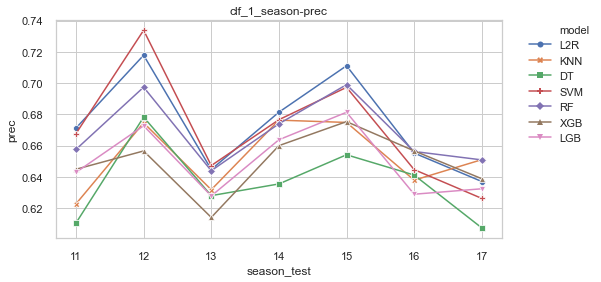

In [90]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment using StandardScaler

In [91]:
experiment_name = f"{exp_prefix}scaled_data"

In [92]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_scaled_data
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
8   clf_scaled_data   KNN   0.674562  0.020809      0.615845     0.016909
11  clf_scaled_data    RF   0.668842  0.021513      0.617785     0.020055
10  clf_scaled_data   SVM   0.666498  0.028956      0.608886     0.023501
7   clf_scaled_data   L2R   0.664626  0.025300      0.607818     0.020121
13  clf_scaled_data   LGB   0.650410  0.021554      0.591523     0.022698
12  clf_scaled_data   XGB   0.649562  0.018604      0.588293     0.022146
9   clf_scaled_data    DT   0.635734  0.021836      0.561554     0.018971

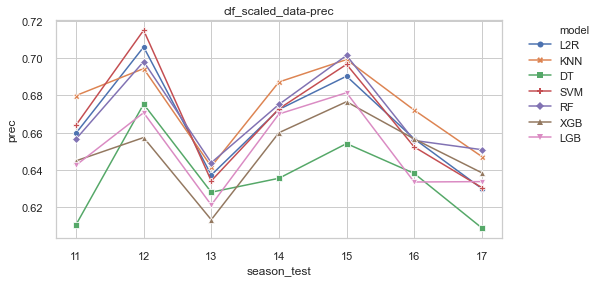

In [93]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))


### Experiment using MinMaxScaler

In [94]:
experiment_name = f"{exp_prefix}minmax_data"

In [95]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_minmax_data
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
15  clf_minmax_data   KNN   0.673869  0.017297      0.613994     0.014225
14  clf_minmax_data   L2R   0.672334  0.029140      0.620613     0.028200
17  clf_minmax_data   SVM   0.670675  0.029608      0.615846     0.029444
18  clf_minmax_data    RF   0.668836  0.020044      0.618048     0.017701
20  clf_minmax_data   LGB   0.652103  0.023800      0.593106     0.026535
19  clf_minmax_data   XGB   0.649062  0.018539      0.587621     0.022072
16  clf_minmax_data    DT   0.635768  0.022148      0.561616     0.019156

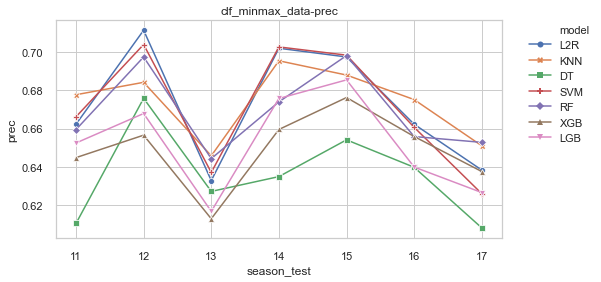

In [96]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment: train: 2s; test: 1s

In [97]:
experiment_name = f"{exp_prefix}2_seasons"

In [98]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)



Running experiment clf_2_seasons
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
21  clf_2_seasons   L2R   0.677250  0.024444      0.628723     0.021661
25  clf_2_seasons    RF   0.673880  0.018666      0.624702     0.017292
24  clf_2_seasons   SVM   0.672358  0.025534      0.623539     0.024163
22  clf_2_seasons   KNN   0.659309  0.015433      0.600656     0.010316
26  clf_2_seasons   XGB   0.658655  0.018470      0.601533     0.016097
27  clf_2_seasons   LGB   0.656851  0.018452      0.601450     0.019626
23  clf_2_seasons    DT   0.637255  0.015853      0.563088     0.010587

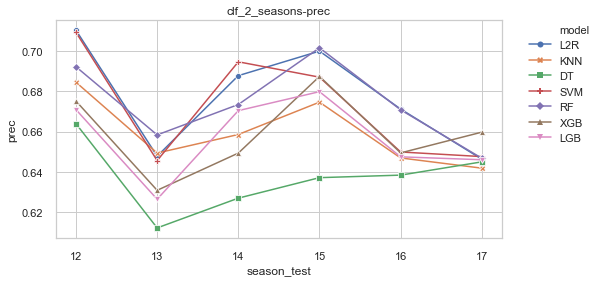

In [99]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment: train: 3s; test: 1s

In [100]:
experiment_name = f"{exp_prefix}3_seasons"

In [101]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3_seasons
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
28  clf_3_seasons   L2R   0.671573  0.019724      0.628254     0.022098
32  clf_3_seasons    RF   0.670956  0.011279      0.627112     0.010201
31  clf_3_seasons   SVM   0.665051  0.018115      0.622282     0.024063
29  clf_3_seasons   KNN   0.661581  0.018248      0.608847     0.017429
33  clf_3_seasons   XGB   0.660021  0.012328      0.611250     0.011103
34  clf_3_seasons   LGB   0.658956  0.015747      0.609761     0.015921
30  clf_3_seasons    DT   0.624549  0.018007      0.552724     0.015294

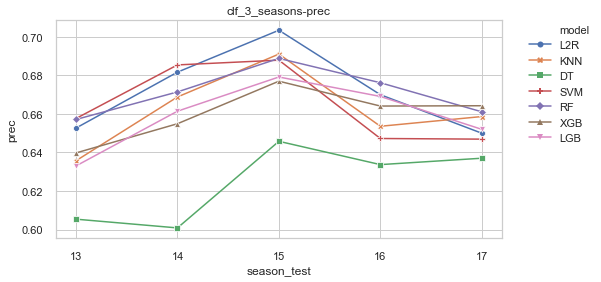

In [102]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment train: 3q ; test: 1q

In [103]:
experiment_name = f"{exp_prefix}3q_1q"

In [104]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
39  clf_3q_1q    RF   0.675334  0.041786      0.623289     0.033246
35  clf_3q_1q   L2R   0.672507  0.048847      0.612287     0.038280
38  clf_3q_1q   SVM   0.666791  0.045969      0.603563     0.034984
40  clf_3q_1q   XGB   0.663762  0.039248      0.601968     0.035289
41  clf_3q_1q   LGB   0.661412  0.040870      0.602006     0.034361
36  clf_3q_1q   KNN   0.658781  0.046660      0.591669     0.038611
37  clf_3q_1q    DT   0.643241  0.039340      0.566361     0.032203

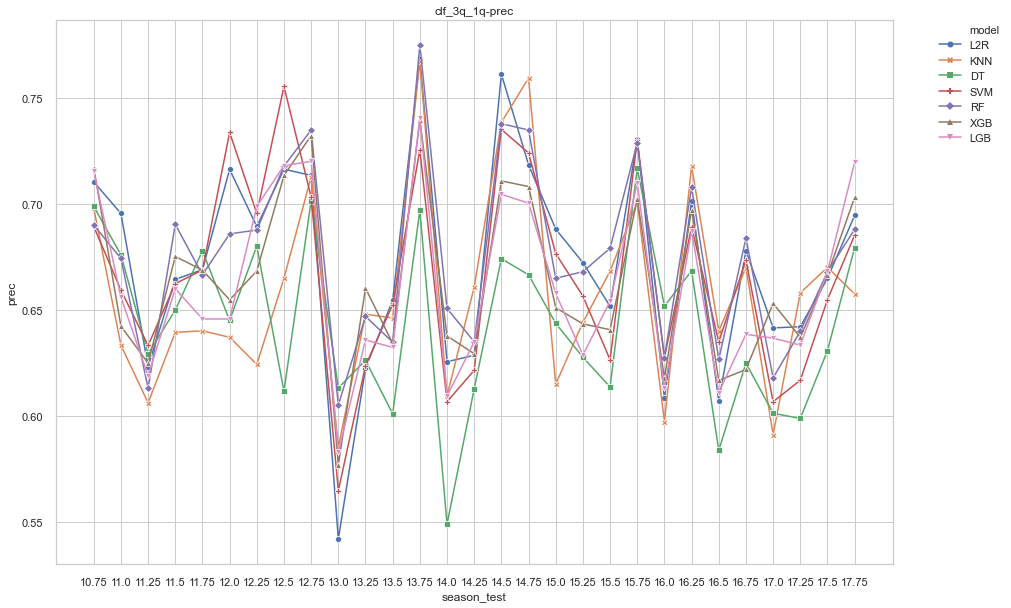

In [105]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

### Experiment train: 4q ; test: 2q

In [106]:
experiment_name = f"{exp_prefix}4q_2q"

In [107]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
42  clf_4q_2q   L2R   0.673316  0.029396      0.619773     0.027535
46  clf_4q_2q    RF   0.673081  0.027098      0.622975     0.024433
45  clf_4q_2q   SVM   0.667504  0.029610      0.610361     0.026625
48  clf_4q_2q   LGB   0.660243  0.027768      0.603060     0.025147
43  clf_4q_2q   KNN   0.658356  0.031612      0.596340     0.031265
47  clf_4q_2q   XGB   0.654686  0.025884      0.595127     0.025521
44  clf_4q_2q    DT   0.639138  0.028632      0.566054     0.024060

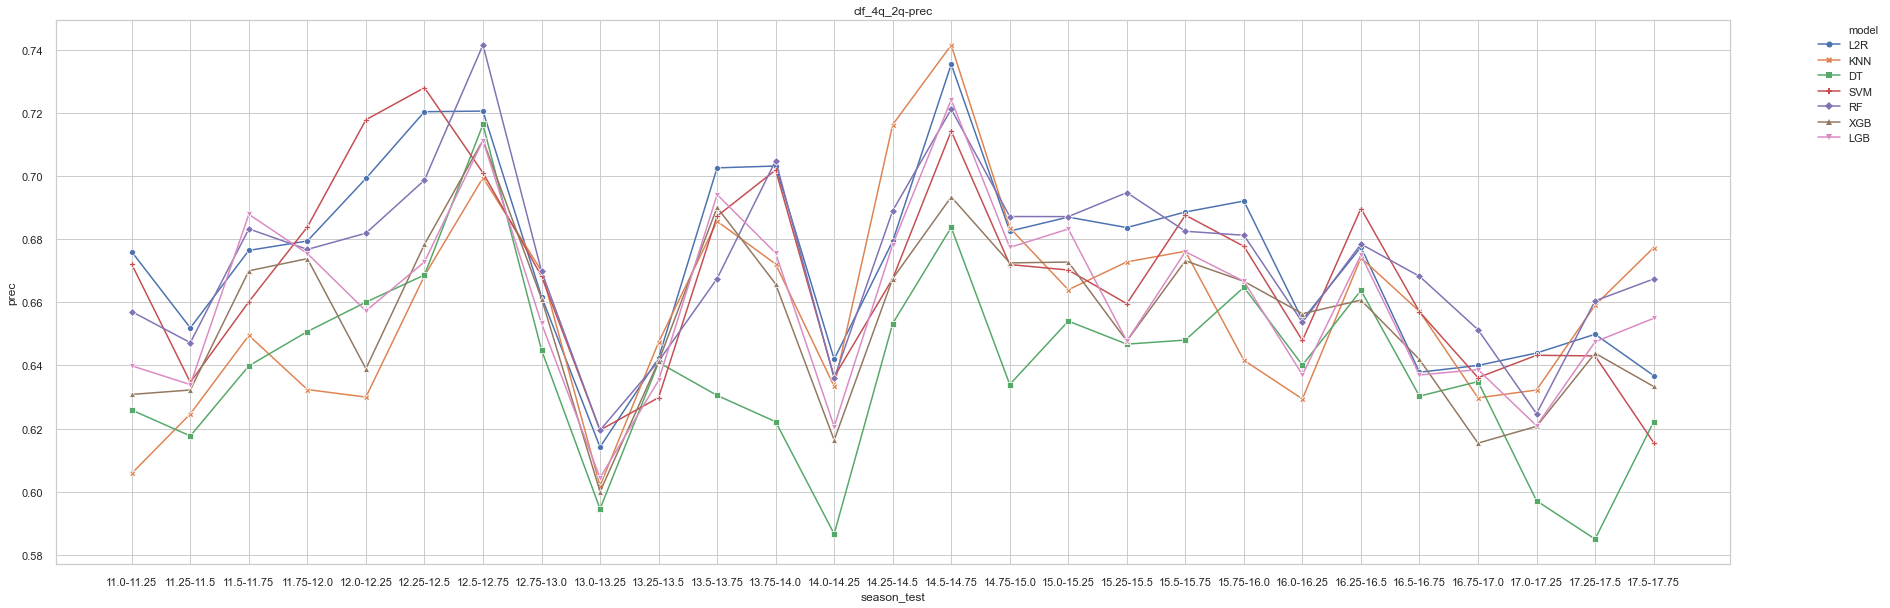

In [108]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(30,10))

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [109]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

In [110]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_r1q_2q_1q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
53  clf_r1q_2q_1q    RF   0.681190  0.042223      0.627217     0.032357
49  clf_r1q_2q_1q   L2R   0.680474  0.042618      0.617978     0.035355
52  clf_r1q_2q_1q   SVM   0.671033  0.044957      0.605963     0.035780
50  clf_r1q_2q_1q   KNN   0.666642  0.044446      0.599137     0.031750
54  clf_r1q_2q_1q   XGB   0.665540  0.042901      0.600895     0.037506
55  clf_r1q_2q_1q   LGB   0.665137  0.043398      0.602466     0.038754
51  clf_r1q_2q_1q    DT   0.640973  0.040265      0.560058     0.034023

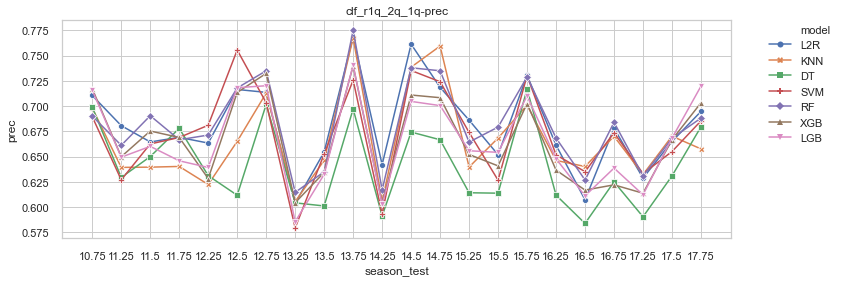

In [111]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(12,4))

### Experiments comparison

In [112]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [113]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [114]:
ba_df = exp_df[['exp_name', 'model',
       'prec_mean', 'prec_std', 'bal_acc_mean', 'bal_acc_std']]

In [115]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [116]:
ba_df.sort_values(
    by=["prec_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
0    clf_r1q_2q_1q    RF   0.681190  0.042223      0.627217     0.032357
1    clf_r1q_2q_1q   L2R   0.680474  0.042618      0.617978     0.035355
2    clf_2_seasons   L2R   0.677250  0.024444      0.628723     0.021661
3        clf_3q_1q    RF   0.675334  0.041786      0.623289     0.033246
4  clf_scaled_data   KNN   0.674562  0.020809      0.615845     0.016909
5     clf_1_season   L2R   0.674052  0.029126      0.620562     0.025533

### Plot experiment results

In [117]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

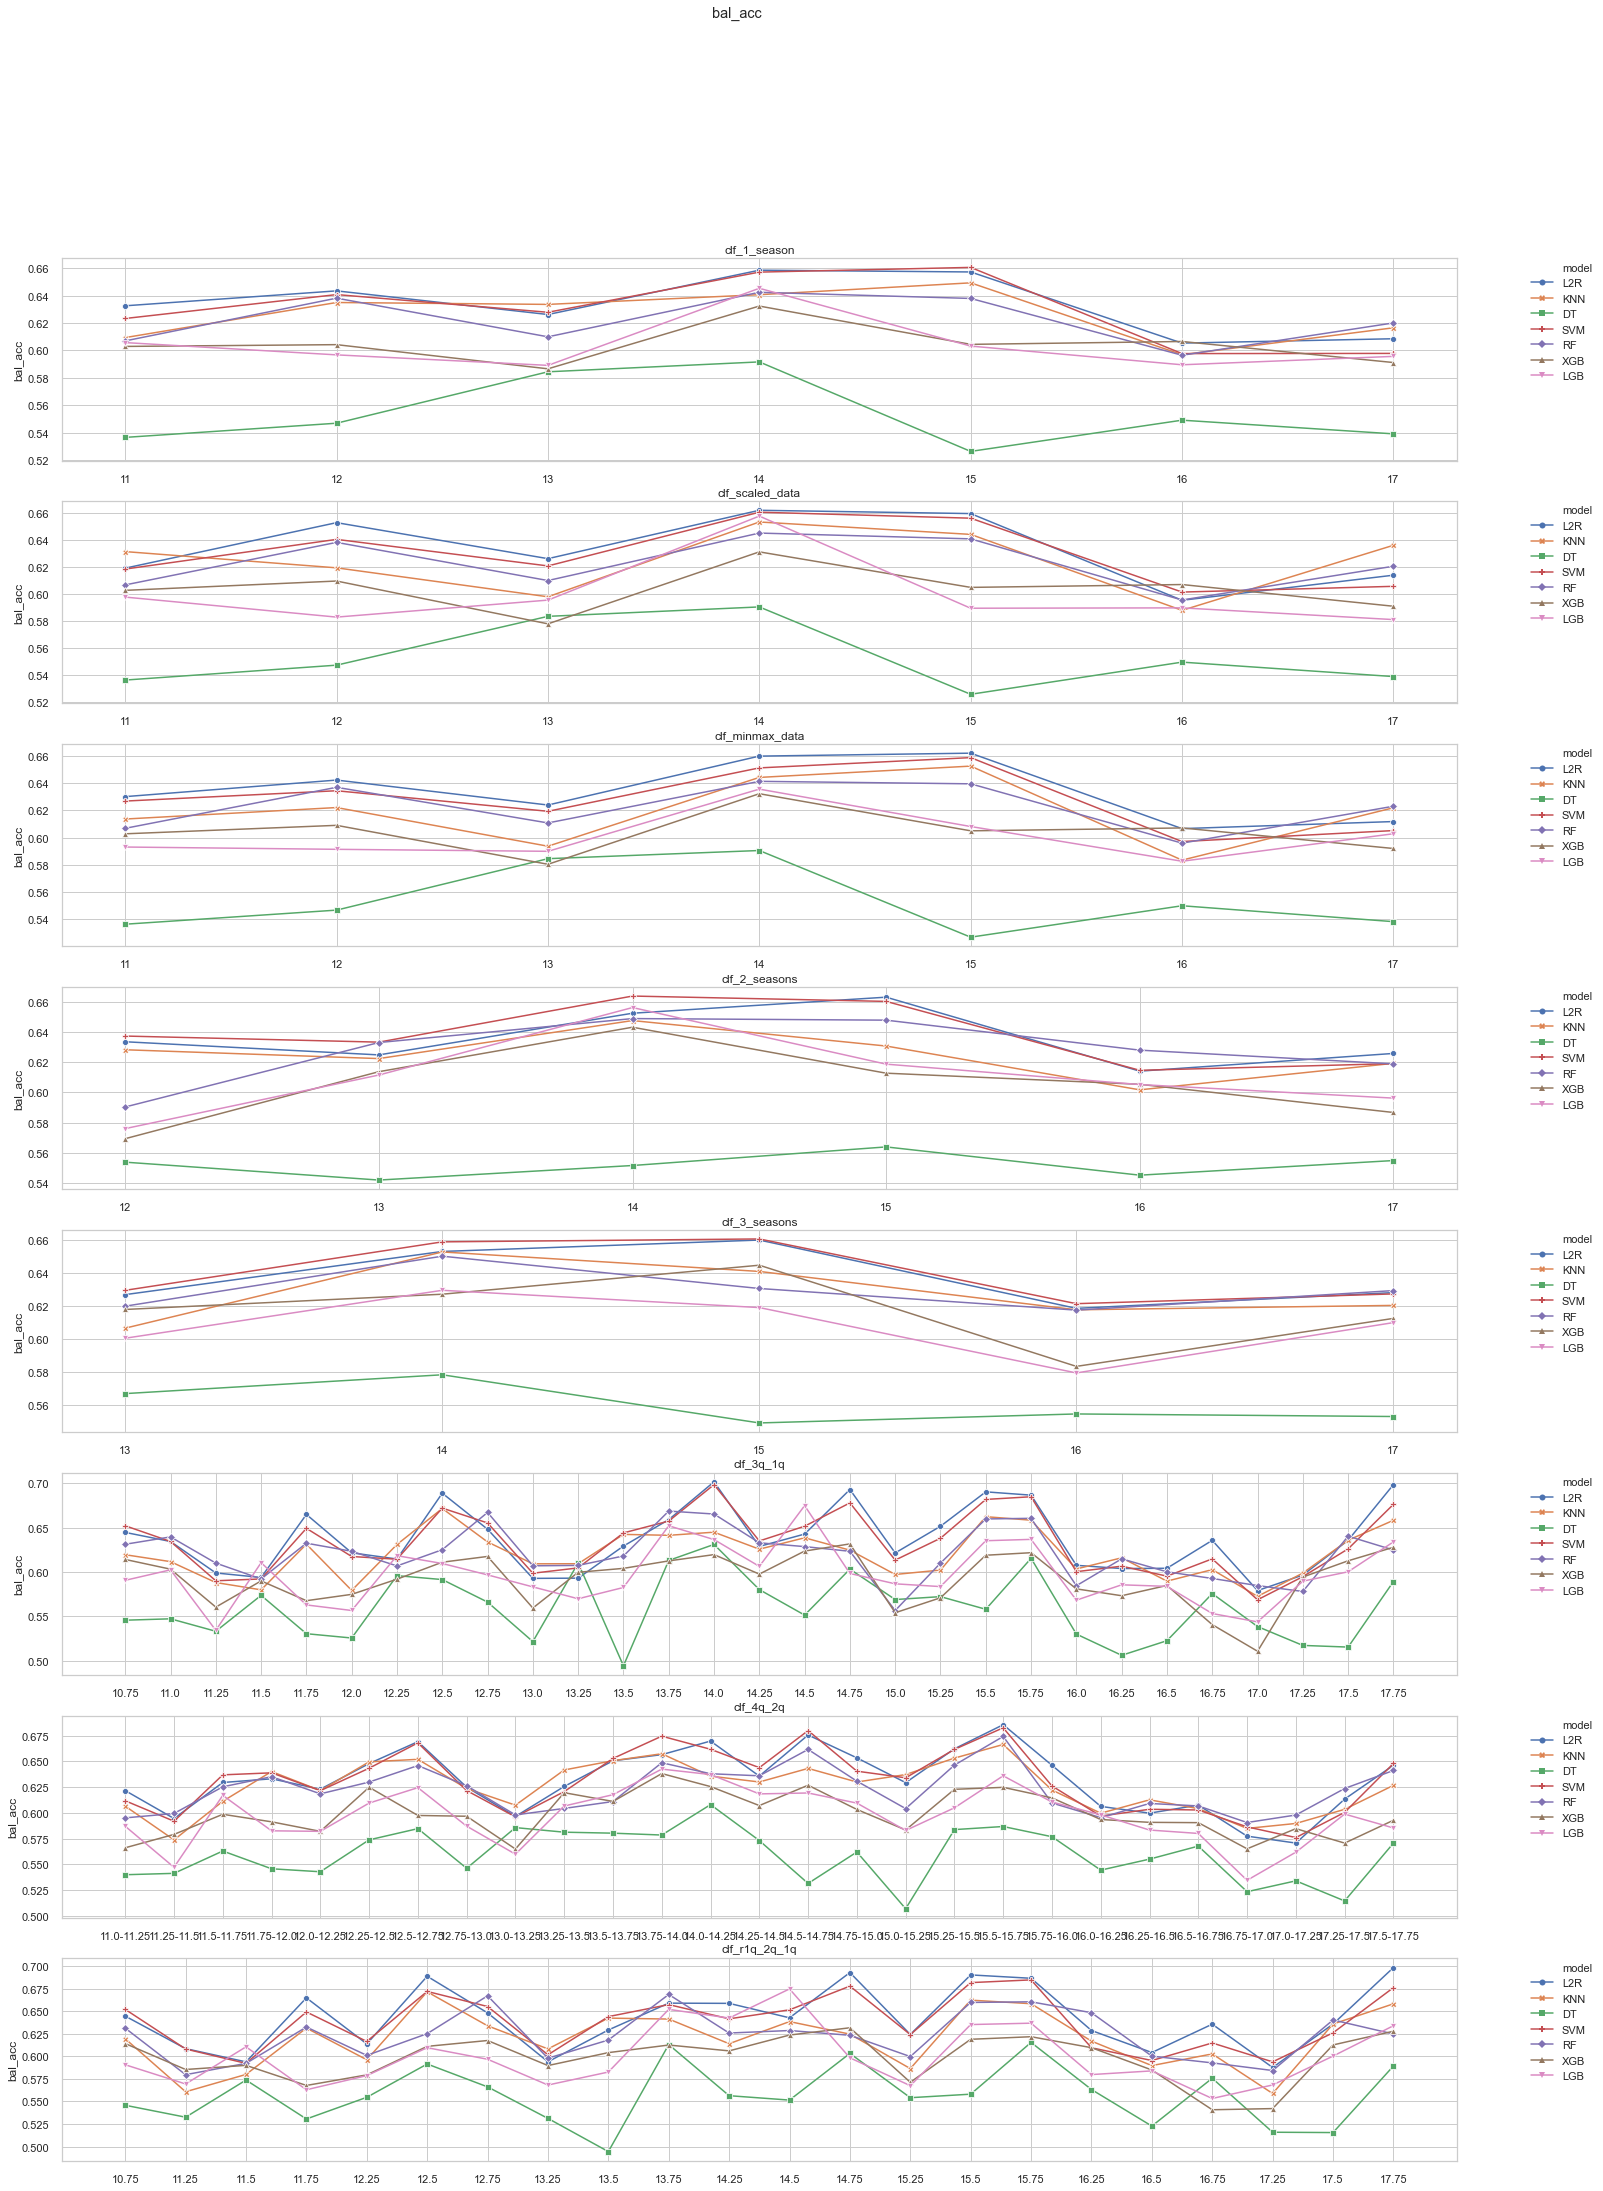

In [82]:
utils.plot_to_compare_experiments(
    results_total,
    metric="bal_acc",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

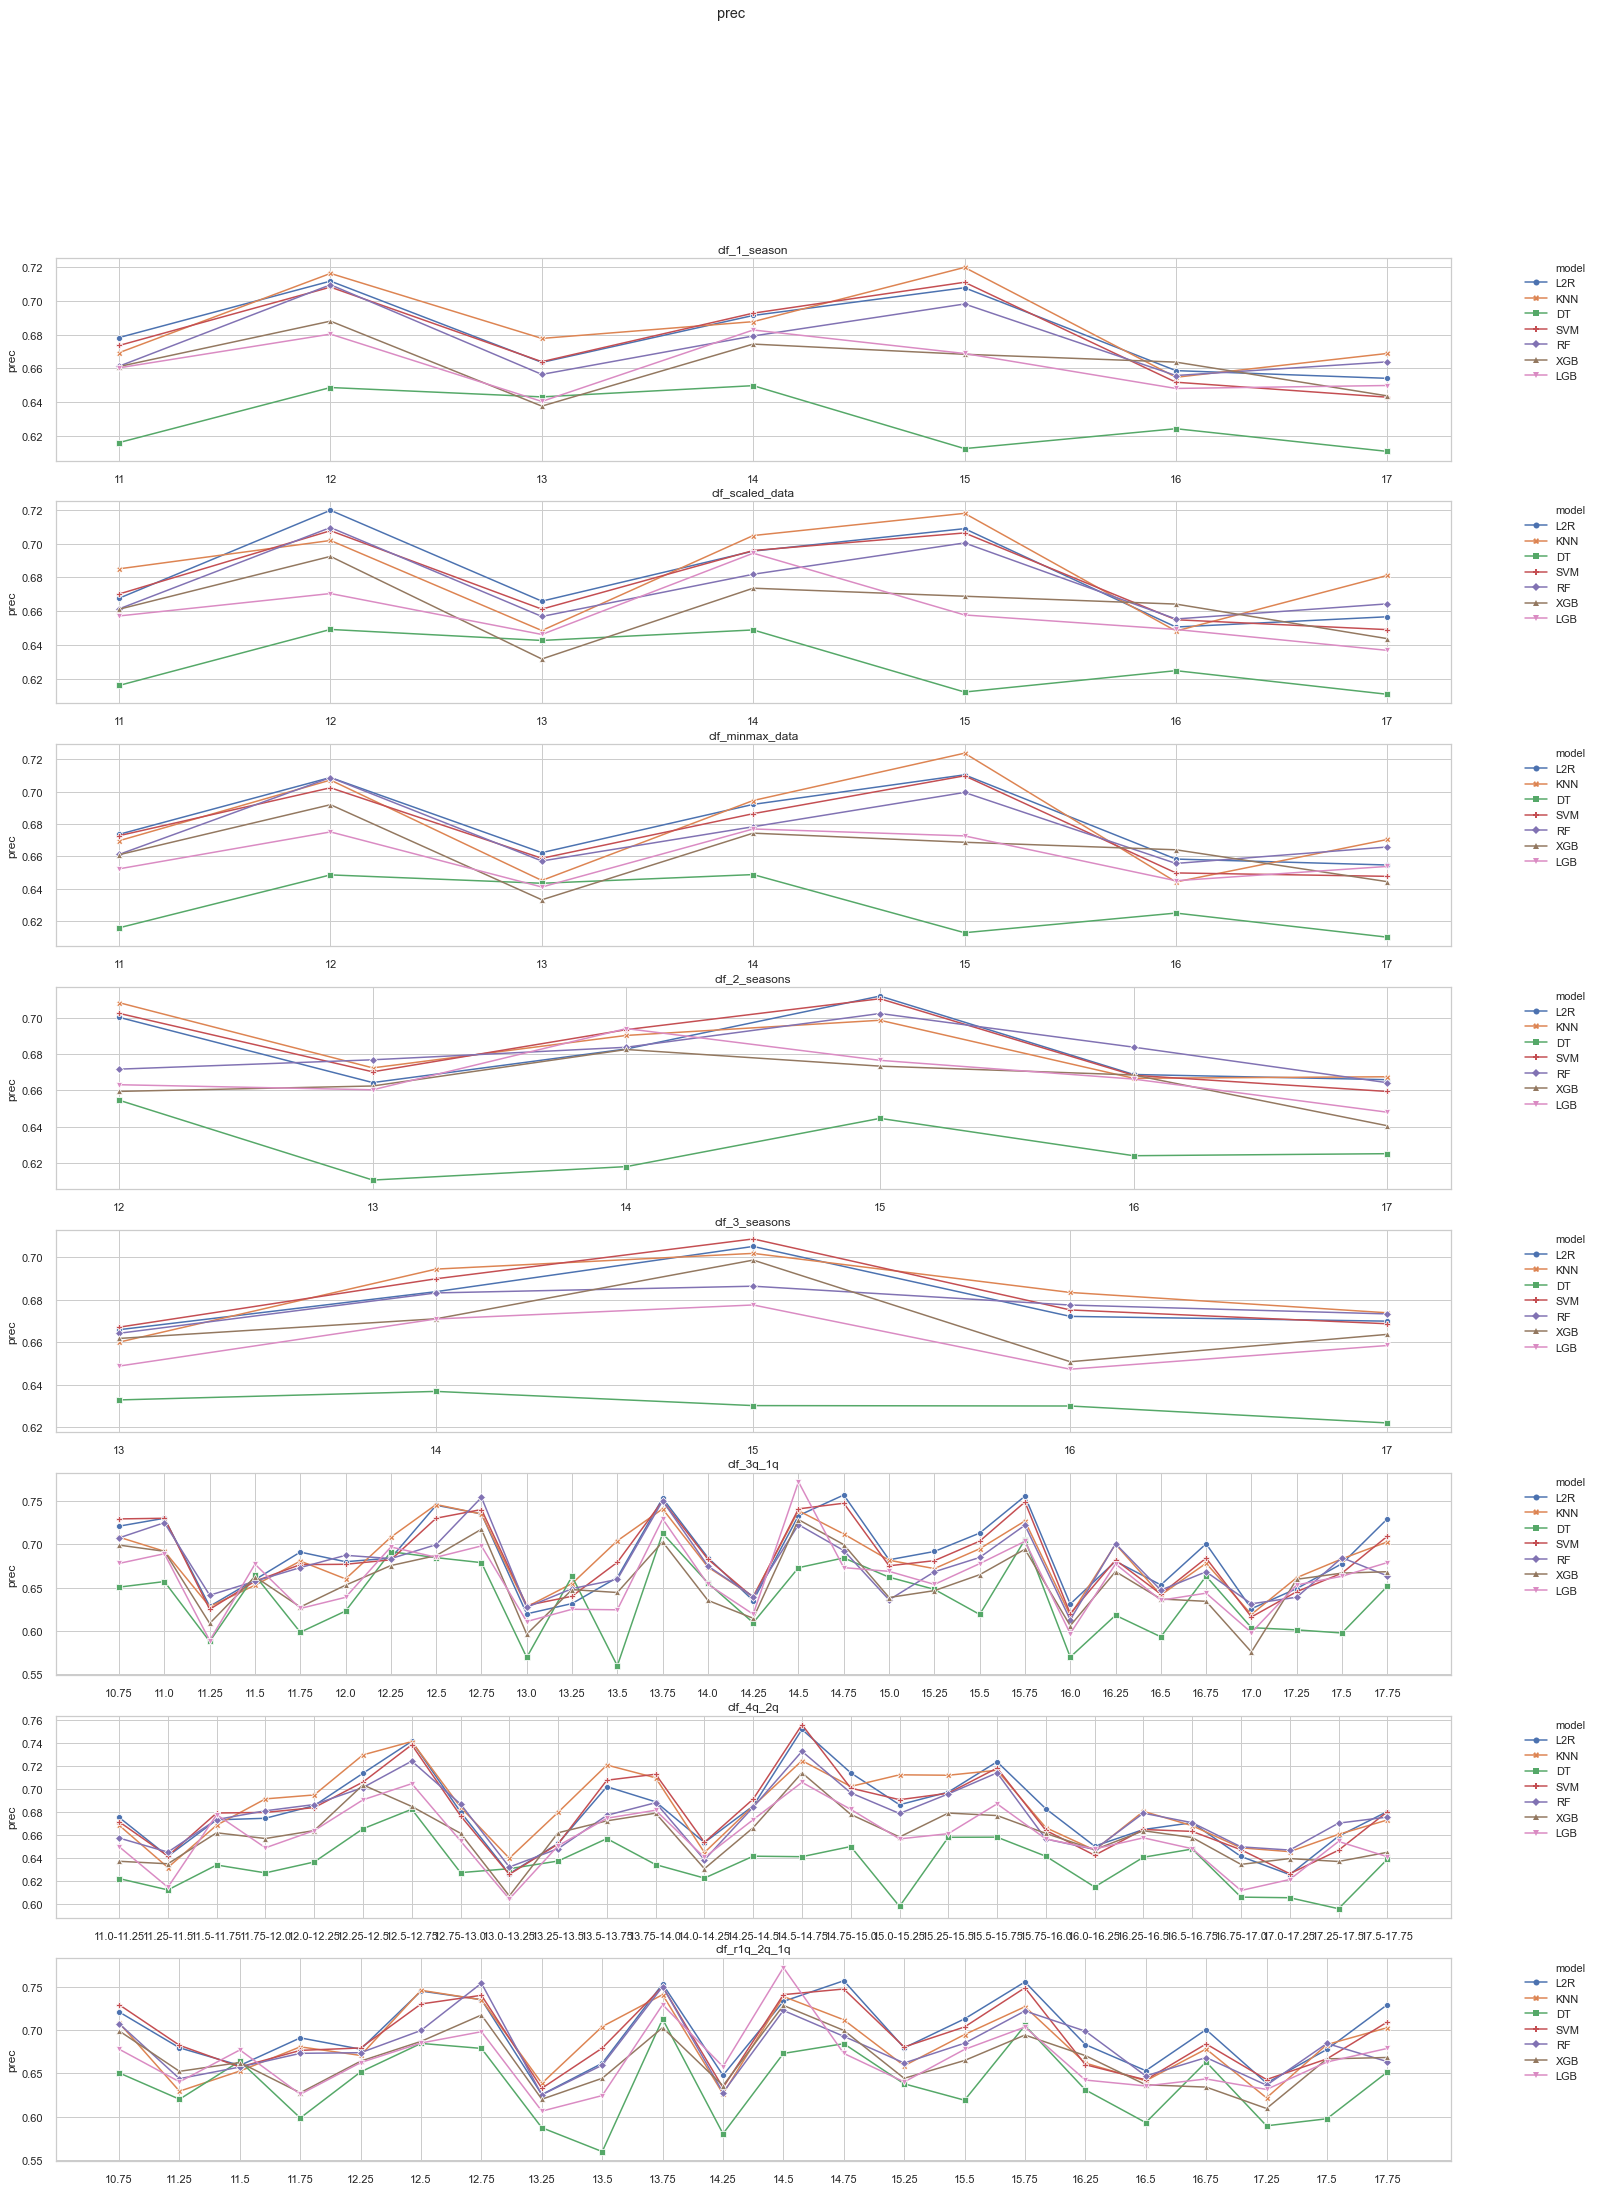

In [83]:
utils.plot_to_compare_experiments(
    results_total,
    metric="prec",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

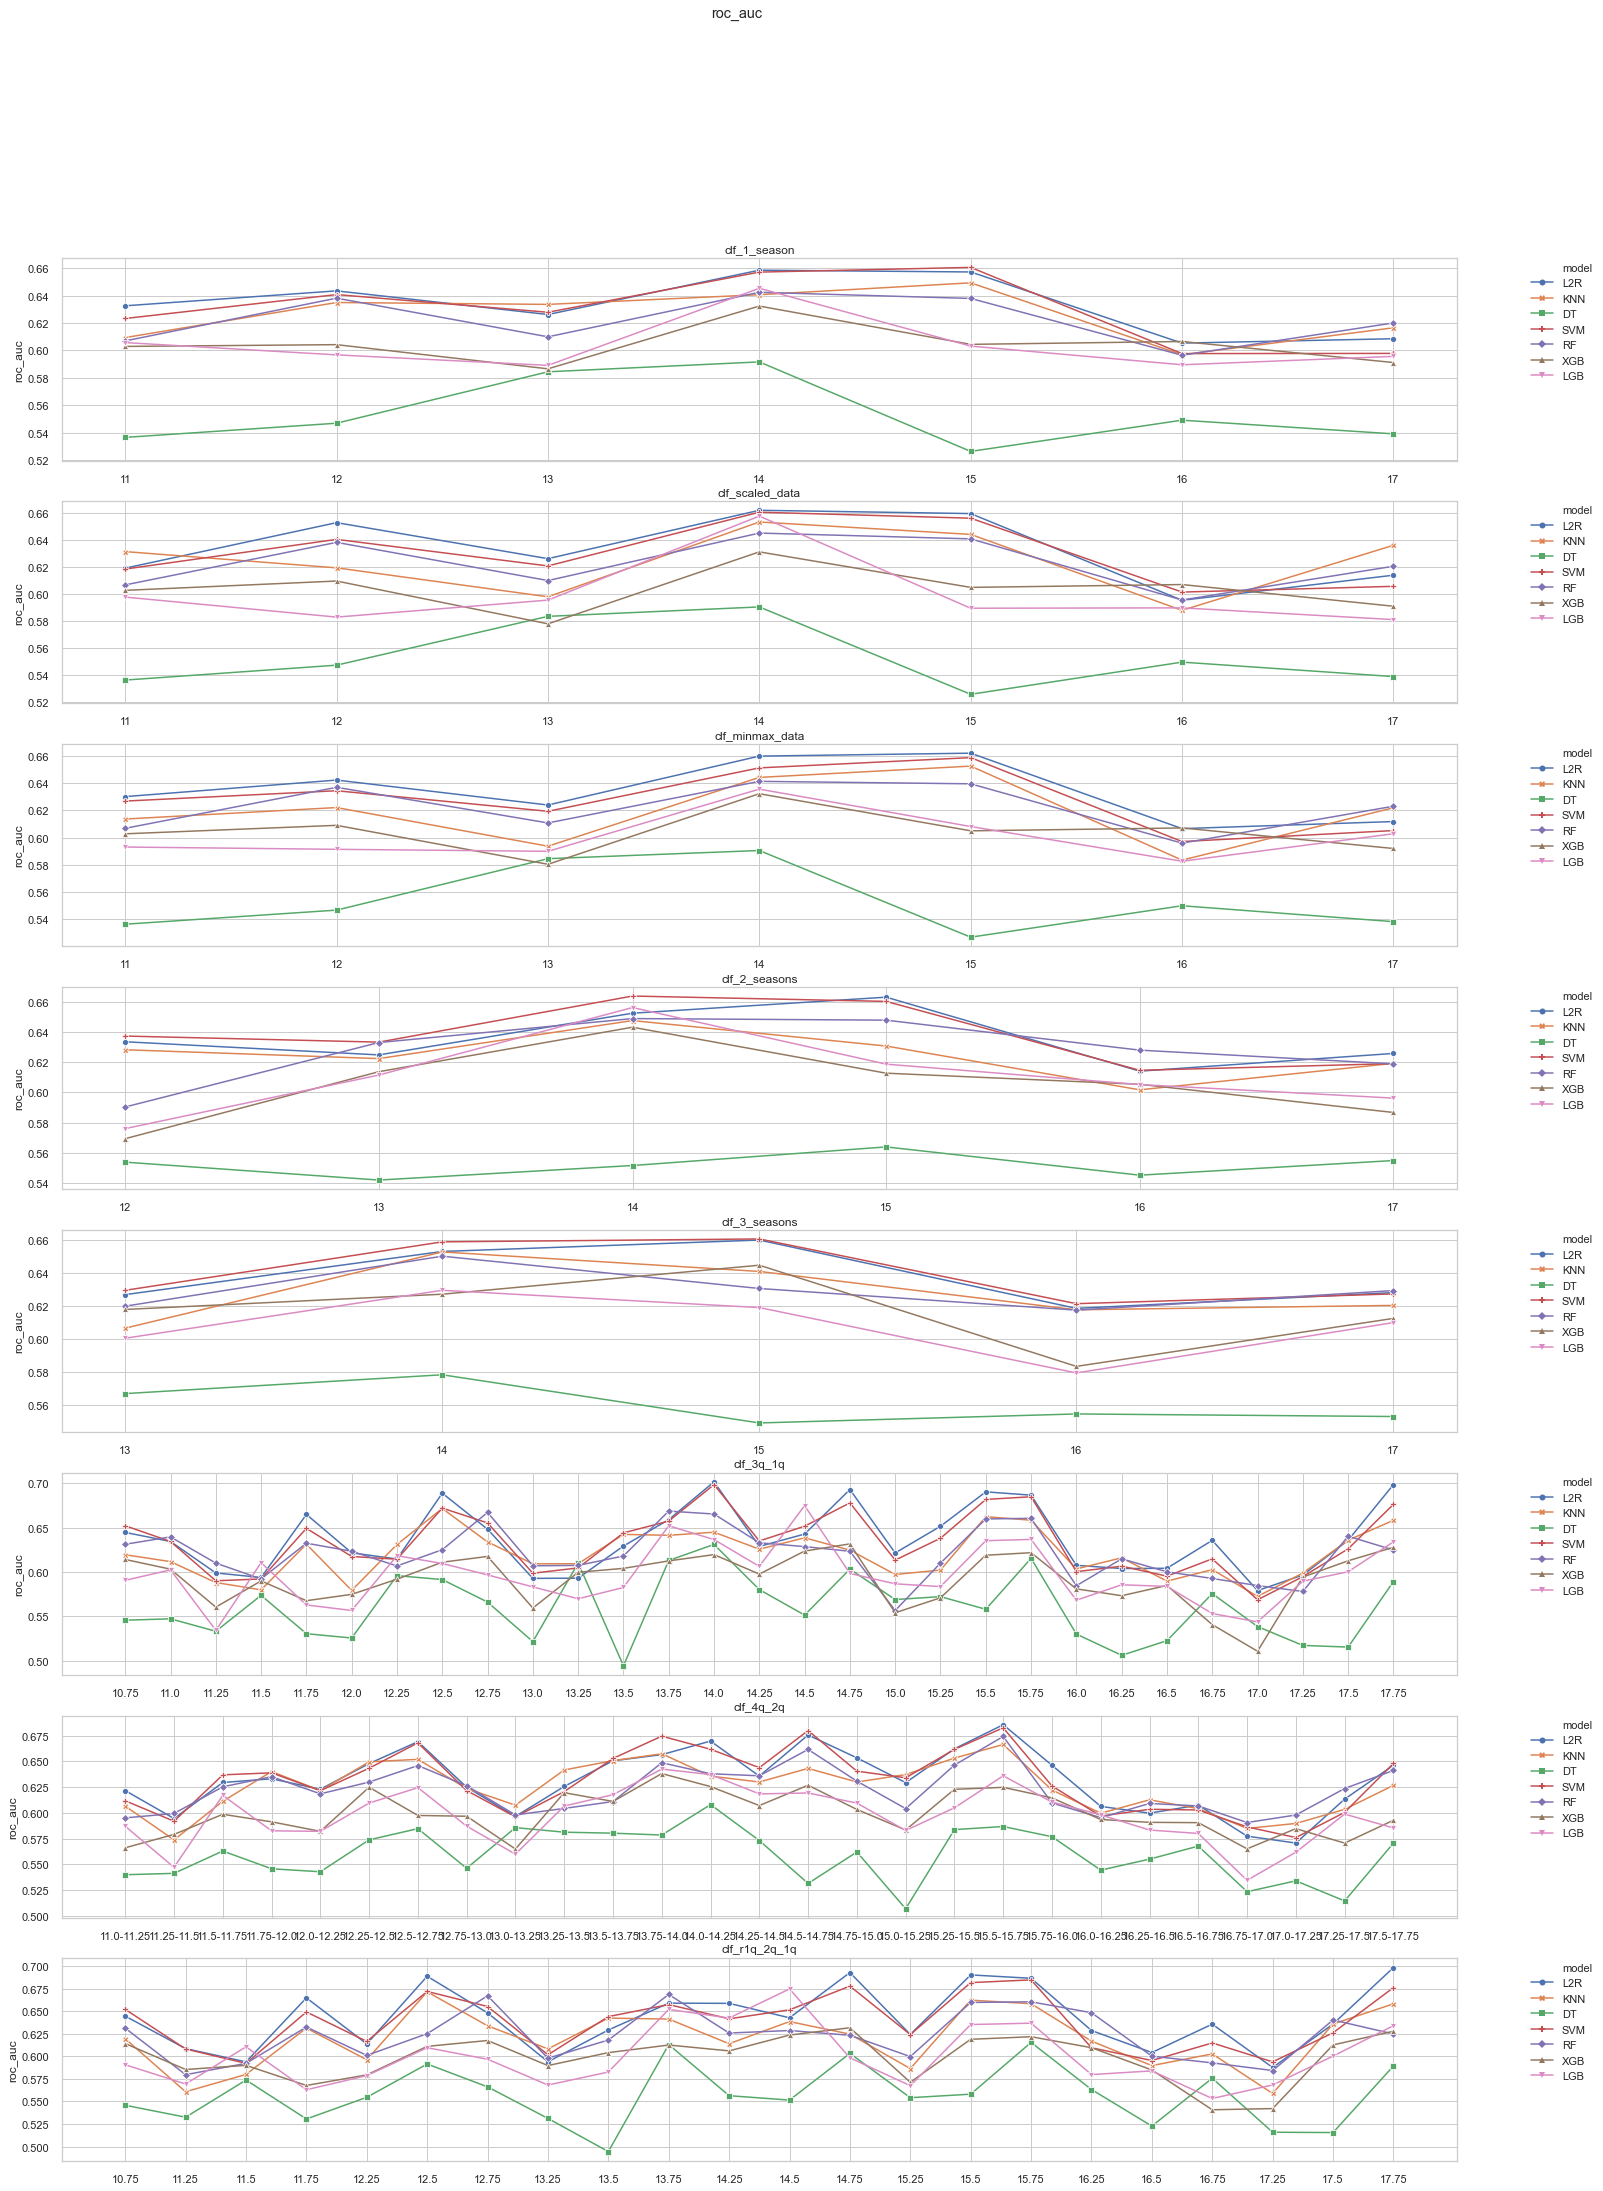

In [84]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)

### Optimization

#### Imports

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import precision_score, \
        balanced_accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hpsklearn import HyperoptEstimator
import hpsklearn
from hyperopt.pyll import scope, as_apply
from hyperopt import SparkTrials, STATUS_OK

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


#### Dataset

In [18]:
op_df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]

##### Seasons

In [19]:
op_df.SEASON.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

##### Clean Data

In [20]:
print(op_df.shape)
op_df = op_df.dropna()
print(op_df.isnull().sum().sum())
print(op_df.isna().sum().sum())
print(op_df.shape)

(9599, 261)
0
0
(9461, 261)


#### setup

In [21]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_op"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

op_models = utils_exp.get_clf_models()

op_sscv = utils.SeasonSeriesSplit(op_df)
op_df_sscv = op_sscv.get_df()
op_X = op_df_sscv[exp_X_columns]
op_y = op_df_sscv[TARGET]

#### Utils

In [22]:
def walk_forward_val_mean_score(input_model):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test
        
        pipeline = Pipeline(steps=[
                ('model', input_model)])
        
        model = pipeline
        fit_info = pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        metric_results.append(balanced_accuracy_score(y_true, y_pred)) 

    return np.mean(metric_results)  


def walk_forward_sklearn(estim):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test
        
        estim.fit(X_train, y_train)
        print(estim.score(X_test, y_test))
        print(estim.best_model())

#### Optimization

In [23]:
folds, train_seasons, test_seasons = op_sscv.split(train_size=2, test_size=1)

In [24]:
# name = 'clf'
# models = [
#     #hpsklearn.svc(name + '.SVM'),
#     #svc_linear
#     #hpsklearn.random_forest(name + '.RF'),
#     #hpsklearn.xgboost_classification(name + '.XGB'),
#     #hpsklearn.lightgbm_classification(name + '.LGB')
#     hpsklearn.svc_linear(name + 'SVM')
# ]


# estim = HyperoptEstimator(classifier=hp.choice('%s' % name, models),
#                           #preprocessing=hpsklearn.any_preprocessing('my_pre'),
#                           preprocessing=None,
#                           algo=tpe.suggest,
#                           max_evals=50,
#                           trial_timeout=120)



# for train_idx, test_idx in folds:
#     X_train, X_test = X.loc[train_idx], X.loc[test_idx]
#     y_train, y_test = y.loc[train_idx], y.loc[test_idx]
#     y_true = y_test
#     estim.fit(X_train, y_train)
#     estim.score(X_test, y_test)

# print(estim.best_model())

#### LGB

In [31]:
space = {
    'max_depth': scope.int(hp.uniform('max_depth', 1, 11)),
    'num_leaves': scope.int(hp.uniform('num_leaves', 2, 121)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)) - 0.0001,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 6000, 200)),
    'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(5)) - 0.0001,
    'min_child_weight': scope.int(hp.loguniform('min_child_weight', np.log(1), np.log(100))),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)) - 0.0001,
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(4)),
    #boosting_type: hp.choice(name, ['gbdt', 'dart', 'goss'])
    'boosting_type': hp.choice('boosting_type', ['gbdt'])
}

default_hiperparameters = {
    'objective': 'binary',
    #'random_state': 0
}

def objective(space):
    print(space)
    hiperparameters = {**default_hiperparameters, **space}
    model = lgb.LGBMClassifier(
        **hiperparameters
    )

    accuracy = walk_forward_val_mean_score(model)

    return {'loss': -accuracy, 'status': STATUS_OK }

spark_trials = SparkTrials(parallelism=4)
#trials = Trials()
best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=150,
        trials=spark_trials,
        rstate=np.random.RandomState(seed=0),
        return_argmin=False
    )
best

100%|██████████| 150/150 [1:57:28<00:00, 46.99s/trial, best loss: -0.7318679777757647] 


Total Trials: 150: 150 succeeded, 0 failed, 0 cancelled.


{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.6108224915520017,
 'colsample_bytree': 0.7991125058203208,
 'gamma': 0.0012626451163248382,
 'learning_rate': 0.0018545119732252533,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 3800,
 'num_leaves': 87,
 'reg_alpha': 0.2835687543880991,
 'reg_lambda': 1.2786968649636916,
 'subsample': 0.5660499077502952}

#### Experiment

In [39]:

op_model = [
#     ('SVM', SVC(C=0.012697068361313206, cache_size=512, degree=1, gamma='auto',
#     kernel='linear', max_iter=54006698.0, random_state=4,
#     tol=8.876549929680088e-05)),
#     ("LGB", lgb.LGBMClassifier(boosting_type='dart', colsample_bytree=0.5774517052371843,
#                learning_rate=0.001088309810177423, max_delta_step=0,
#                max_depth=9, min_child_weight=22, n_estimators=3200, n_jobs=1,
#                num_leaves=19, objective='binary',
#                reg_alpha=0.0009920138640525102, reg_lambda=2.593449218886441,
#                scale_pos_weight=1, seed=3, subsample=0.980626212446999)),
    ('LGB', lgb.LGBMClassifier(
        **{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.7911287100076613,
 'colsample_bytree': 0.8603649524735973,
 'gamma': 4.43302024049316,
 'learning_rate': 0.0009592641656631401,
 'max_depth': 3,
 'min_child_weight': 17,
 'n_estimators': 4000,
 'num_leaves': 72,
 'reg_alpha': 1.0620929521387056e-05,
 'reg_lambda': 1.3493051864867296,
 'subsample': 0.9099643557200597}
    )),
    ('LGB2', lgb.LGBMClassifier(
        **{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.7729132785100075,
 'colsample_bytree': 0.8237696281830607,
 'gamma': 0.02767717987305845,
 'learning_rate': 0.004301947480128295,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 1400,
 'num_leaves': 101,
 'reg_alpha': 0.0004447330199770369,
 'reg_lambda': 1.1974372235637603,
 'subsample': 0.6524249725030407}
    )),
    ('LGB3', lgb.LGBMClassifier(**
    {'boosting_type': 'gbdt',
 'colsample_bylevel': 0.6108224915520017,
 'colsample_bytree': 0.7991125058203208,
 'gamma': 0.0012626451163248382,
 'learning_rate': 0.0018545119732252533,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 3800,
 'num_leaves': 87,
 'reg_alpha': 0.2835687543880991,
 'reg_lambda': 1.2786968649636916,
 'subsample': 0.5660499077502952})),
    ("XGB", xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9274316569938598, colsample_bynode=1,
              colsample_bytree=0.768350297812703, gamma=0.275559851080226,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00383884756104703, max_delta_step=0, max_depth=2,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=5600, n_jobs=1, num_parallel_tree=1, random_state=3,
              reg_alpha=1.6862525411636347e-05, reg_lambda=1.976163318531772,
              scale_pos_weight=1, seed=3, subsample=0.9990805503135648,
              tree_method='exact', validate_parameters=1, verbosity=None)),
    
    ("XGB2", xgb.XGBClassifier(**{'colsample_bylevel': 0.6377999154047157,
 'colsample_bytree': 0.9842293615322797,
 'gamma': 0.0005531486918297421,
 'learning_rate': 0.0007474569779455549,
 'max_depth': 10,
 'min_child_weight': 6,
 'n_estimators': 4600,
 'reg_alpha': 0.011708580861937797,
 'reg_lambda': 2.0311282671384228,
 'subsample': 0.5680268128073964})
    )
]

model_names = ['LGB', 'XGB']

In [40]:
experiment_name = f"{exp_prefix}2_seasons_op"
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, op_model, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name[:-3], metric='prec', filter_val= names)
print_prettier_exp_results(experiment_name)
# 11	clf_2_seasons	SVM	0.760366	0.011854	0.728416	0.012863
    # 8	clf_2_seasons	L2R	0.760026	0.011737	0.728800	0.014623
# 12	clf_2_seasons	RF	0.758332	0.011720	0.724693	0.010767
# 13	clf_2_seasons	XGB	0.748373	0.005121	0.706205	0.006501
# 14	clf_2_seasons	LGB	0.743551	0.005716	0.702446	0.006115

#XGB	0.74998	0.00996	0.721646	


Running experiment clf_2_seasons_op
Done


Empty DataFrame
Columns: [exp_name, model, prec_mean, prec_std, bal_acc_mean, bal_acc_std]
Index: []

exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
2  clf_2_seasons_op  LGB3   0.764682  0.008933      0.731868     0.011893
0  clf_2_seasons_op   LGB   0.764012  0.010939      0.731917     0.012155
1  clf_2_seasons_op  LGB2   0.763515  0.008504      0.728363     0.008645
3  clf_2_seasons_op   XGB   0.759969  0.010427      0.724662     0.010840
4  clf_2_seasons_op  XGB2   0.759758  0.012012      0.724763     0.011260

TypeError: cannot unpack non-iterable NoneType object

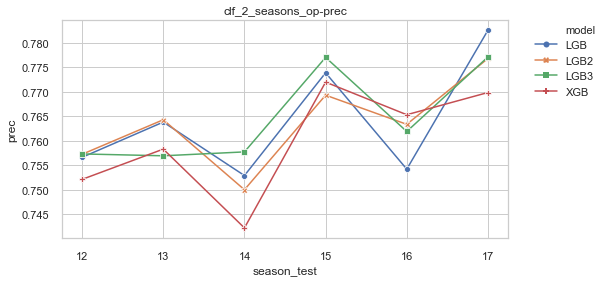

In [37]:
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))
name, res = get_result_by(experiment_name[:-3])

res = [x for x in res if x['model'][0] in model_names] 
plot_results(name[:-3], res, figsize=(8,4))

### Final validation

#### Dataset

In [15]:
fv_df = season_games[(season_games.SEASON >= 2016)]

##### Seasons

In [16]:
fv_df.SEASON.unique()

array([2016, 2017, 2018, 2019])

##### clean data

In [17]:
print(fv_df.shape)
fv_df = fv_df.dropna()
print(fv_df.isnull().sum().sum())
print(fv_df.isna().sum().sum())
print(fv_df.shape)

(4749, 261)
0
0
(4685, 261)


#### setup

In [18]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_final_validation"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

fv_models = utils_exp.get_clf_models()

fv_sscv = utils.SeasonSeriesSplit(fv_df)
fv_df_sscv = fv_sscv.get_df()
fv_X = fv_df_sscv[exp_X_columns]
fv_y = fv_df_sscv[TARGET]

#### experiment

In [19]:
experiment_name = f"{exp_prefix}2_seasons_fv"

In [20]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = fv_sscv.split(train_size=2, test_size=1)
params = (experiment_name, fv_models, folds, train_seasons, test_seasons, fv_X, fv_y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_fv
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
4  clf_2_seasons_fv    RF   0.762396  0.033825      0.738084     0.020561
3  clf_2_seasons_fv   SVM   0.761851  0.029544      0.745272     0.016139
0  clf_2_seasons_fv   L2R   0.757738  0.028254      0.742014     0.013661
6  clf_2_seasons_fv   LGB   0.749895  0.025701      0.716310     0.007497
5  clf_2_seasons_fv   XGB   0.741749  0.025189      0.711492     0.009271
2  clf_2_seasons_fv    DT   0.700006  0.008087      0.650257     0.012661
1  clf_2_seasons_fv   KNN   0.659587  0.024073      0.613094     0.007160

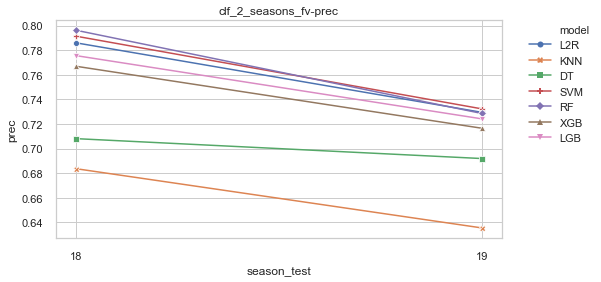

In [21]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))